In [139]:
# Packages that may need to be installed to run
#pip install opencv-python


In [166]:
import numpy as np 
import cv2
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt       
%matplotlib inline

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [141]:
# Data Cleaning
# Data source cite: https://github.com/gabrieldgf4/PlantVillage-Dataset
# Repost from the plantvillage.org repository that is no longer available

# Setting filters for the images hsv colors
low_hsv = (0,60,0)
high_hsv = (179,255,255)


#cleaning the images
def cleaning_image(images):
    clean_image = []
    for image in images:
        gray_scale = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(gray_scale, low_hsv,high_hsv)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=np.ones((8,8),dtype=np.uint8))
        clean_image.append(cv2.bitwise_and(image, image,mask=mask))
    return clean_image

# Getting healthy leaf images (#1000)
Toma_healthy = [cv2.imread(file) for file in glob.glob(r'TomatoDataset/Tomato_healthy/*.JPG')]
Toma_healthy_cleaned = cleaning_image(Toma_healthy)

# Getting moldy leaf images (# 952)
Toma_mold  = [cv2.imread(file) for file in glob.glob(r'TomatoDataset/Tomato_leaf_mold/*.JPG')]
Toma_mold_cleaned = cleaning_image(Toma_mold)

# Getting bacterial spot images (# 1000)
Toma_bact_spot  = [cv2.imread(file) for file in glob.glob(r'TomatoDataset/Tomato_bacterial_spot/*.JPG')]

Toma_bact_spot_clean = cleaning_image(Toma_bact_spot)

print(f"Total Tomato Bacterial Spot Images: {len(Toma_bact_spot)}")
print(f"Total Cleaned Images: {len(Toma_bact_spot_clean)}")


Total Tomato Bacterial Spot Images: 1000
Total Cleaned Images: 1000


In [142]:
# Image Checker
# cv2.imshow("Image", Toma_bact_spot_clean[88])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [143]:
# Feature gathering code
# Takes in image list and label, returns pandas datafram of features

def feature_gathering(images, label):
    red_mean = []
    blue_mean = []
    green_mean = []
    contrast = [] # not used yet. Need to download a package to get this feature
    labels = [label]*len(images)
    for image in images:
        red_mean.append(np.mean(image[:,:,0]))
        blue_mean.append(np.mean(image[:,:,1]))
        green_mean.append(np.mean(image[:,:,2]))
        
    return pd.DataFrame({"label":labels, "RedMean":red_mean, "BlueMean":blue_mean, "GreenMean": green_mean})

In [144]:
# uncleaned images
Toma_healthy_df = feature_gathering(Toma_healthy, 1)
Toma_mold_df = feature_gathering(Toma_mold, 2)
Toma_bact_spot_df = feature_gathering(Toma_bact_spot, 3)

uncleaned_leaves_df = pd.concat([Toma_healthy_df,Toma_mold_df,Toma_bact_spot_df], axis =0)
unclean_X = uncleaned_leaves_df.drop(columns= ["label"], axis = 1)
unclean_y = uncleaned_leaves_df["label"]

In [145]:
# cleaned images
Toma_healthy_df = feature_gathering(Toma_healthy_cleaned, 1)
Toma_mold_df  = feature_gathering(Toma_mold_cleaned, 2)
Toma_bact_spot_df = feature_gathering(Toma_bact_spot, 3)

cleaned_leaves_df = pd.concat([Toma_healthy_df,Toma_mold_df,Toma_bact_spot_df], axis =0)
clean_X = cleaned_leaves_df.drop(columns= ["label"], axis = 1)
clean_y = cleaned_leaves_df["label"]


In [146]:
def normalize_label(name_str):
    # Remove spaces and parentheses, then take the first two parts split by '_'
    name_str = name_str.replace(" ", "")
    name_str = name_str.translate(name_str.maketrans("", "", "()"))
    parts = name_str.split("_")
    return ''.join(parts[:2])

def normalize_desc(folder, sub_folder):
    text = folder + " - " + sub_folder 
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    return text.strip()

def print_progress(val, val_len, folder, sub_folder, filename, bar_size=10):
    progr = "#" * round(val * bar_size / val_len) + " " * round((val_len - val) * bar_size / val_len)
    print(f"[{progr}] folder: {folder}/{sub_folder}/ ----> file: {filename}", end="\r")

In [147]:
def feature_gathering_with_glcm(images, label):
    # Define GLCM parameters
    properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    angle_names = ['0', '45', '90', '135']
    
    data = []
    for image in images:
        if image is None:
            # If an image failed to load, assign NaN to all features
            row = {"RedMean": np.nan, "GreenMean": np.nan, "BlueMean": np.nan}
            for prop in properties:
                for ang in angle_names:
                    row[f"{prop}_{ang}"] = np.nan
            row["label"] = label
            data.append(row)
            continue
        
        # Extract color features (note: OpenCV uses BGR)
        red_mean = np.mean(image[:, :, 2])
        green_mean = np.mean(image[:, :, 1])
        blue_mean = np.mean(image[:, :, 0])
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        glcm = graycomatrix(gray, distances=[5], angles=angles, levels=256, symmetric=True, normed=True)
        
        # Extract texture features from the GLCM for each property and angle
        glcm_features = {}
        for prop in properties:
            vals = graycoprops(glcm, prop).flatten()  
            for i, ang in enumerate(angle_names):
                glcm_features[f"{prop}_{ang}"] = vals[i]
        
        # Combine features into single row
        row = {
            "RedMean": red_mean,
            "GreenMean": green_mean,
            "BlueMean": blue_mean
        }
        row.update(glcm_features)
        row["label"] = label
        data.append(row)
        
    return pd.DataFrame(data)

In [148]:
def compute_lbp_histogram(image, num_points=8, radius=1, method="uniform"):
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Compute LBP codes
    lbp = local_binary_pattern(gray, num_points, radius, method=method)
    
    # Build the histogram
    n_bins = num_points + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    
    # Normalize
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    
    return hist

In [149]:
def feature_gathering_with_lbp(images, label):
    data = []
    
    for image in images:
        # If image is None, skip or fill with NaNs
        if image is None:
            row = {
                "RedMean": np.nan,
                "GreenMean": np.nan,
                "BlueMean": np.nan
            }
            for i in range(10):
                row[f"LBP_{i}"] = np.nan
            row["label"] = label
            data.append(row)
            continue
        
        # Color means (OpenCV = BGR)
        red_mean   = np.mean(image[:, :, 2])
        green_mean = np.mean(image[:, :, 1])
        blue_mean  = np.mean(image[:, :, 0])
        
        # Compute LBP histogram
        lbp_hist = compute_lbp_histogram(image, num_points=8, radius=1, method="uniform")
        
        # Build row
        row = {
            "RedMean": red_mean,
            "GreenMean": green_mean,
            "BlueMean": blue_mean
        }
        
        # Add LBP histogram bins as separate features
        for i, val in enumerate(lbp_hist):
            row[f"LBP_{i}"] = val
        
        row["label"] = label
        
        data.append(row)
    
    return pd.DataFrame(data)

In [150]:
# Extract features for uncleaned images
Toma_healthy_df_unclean = feature_gathering_with_glcm(Toma_healthy, 1)
Toma_mold_df_unclean    = feature_gathering_with_glcm(Toma_mold, 2)
Toma_bact_spot_df_unclean = feature_gathering_with_glcm(Toma_bact_spot, 3)

uncleaned_leaves_df = pd.concat([Toma_healthy_df_unclean, Toma_mold_df_unclean, Toma_bact_spot_df_unclean], axis=0, ignore_index=True)
unclean_X_glcm = uncleaned_leaves_df.drop(columns=["label"], axis=1)
unclean_y_glcm = uncleaned_leaves_df["label"]

In [151]:
# Extract features for cleaned images
Toma_healthy_df_clean = feature_gathering_with_glcm(Toma_healthy_cleaned, 1)
Toma_mold_df_clean    = feature_gathering_with_glcm(Toma_mold_cleaned, 2)
Toma_bact_spot_df_clean = feature_gathering_with_glcm(Toma_bact_spot_clean, 3)

cleaned_leaves_df = pd.concat([Toma_healthy_df_clean, Toma_mold_df_clean, Toma_bact_spot_df_clean], axis=0, ignore_index=True)
clean_X_glcm = cleaned_leaves_df.drop(columns=["label"], axis=1)
clean_y_glcm = cleaned_leaves_df["label"]

In [152]:
Toma_healthy_df_unclean_lbp = feature_gathering_with_lbp(Toma_healthy, 1)
Toma_mold_df_unclean_lbp    = feature_gathering_with_lbp(Toma_mold, 2)
Toma_bact_spot_df_unclean_lbp = feature_gathering_with_lbp(Toma_bact_spot, 3)

uncleaned_leaves_df = pd.concat([
    Toma_healthy_df_unclean_lbp,
    Toma_mold_df_unclean_lbp,
    Toma_bact_spot_df_unclean_lbp
], axis=0, ignore_index=True)

unclean_X_lbph = uncleaned_leaves_df.drop(columns=["label"], axis=1)
unclean_y_lbph = uncleaned_leaves_df["label"]

In [153]:
Toma_healthy_df_clean_lbp = feature_gathering_with_lbp(Toma_healthy_cleaned, 1)
Toma_mold_df_clean_lbp    = feature_gathering_with_lbp(Toma_mold_cleaned, 2)
Toma_bact_spot_df_clean_lbp = feature_gathering_with_lbp(Toma_bact_spot_clean, 3)

cleaned_leaves_df = pd.concat([
    Toma_healthy_df_clean_lbp,
    Toma_mold_df_clean_lbp,
    Toma_bact_spot_df_clean_lbp
], axis=0, ignore_index=True)

clean_X_lbph = cleaned_leaves_df.drop(columns=["label"], axis=1)
clean_y_lbph = cleaned_leaves_df["label"]

In [176]:
def combine_features(X_glcm, X_lbph):
    X_glcm = np.array(X_glcm)
    X_lbph = np.array(X_lbph)

    scaler = StandardScaler()
    X_glcm_scaled = scaler.fit_transform(X_glcm)
    X_lbph_scaled = scaler.fit_transform(X_lbph)

    X_combined = np.hstack((X_glcm_scaled, X_lbph_scaled))

    return X_combined

In [177]:
X_combined = combine_features(unclean_X_glcm, unclean_X_lbph)
X_combined_clean = combine_features(clean_X_glcm, clean_X_lbph)



In [154]:
# SVM Model Maker
Leaf_svm = SVC(kernel='rbf', C = 100,)

In [155]:
# Cross_val_score unclean
kf = KFold(n_splits= 10, shuffle = True)
scores = cross_val_score(Leaf_svm, unclean_X, unclean_y, cv=kf)
print("The unclean Cross Val score = ",np.average(np.absolute(scores)))

kf = KFold(n_splits= 10, shuffle = True)
scores = cross_val_score(Leaf_svm, unclean_X_glcm, unclean_y_glcm, cv=kf)
print("The unclean Cross Val score with GLCM = ",np.average(np.absolute(scores)))

kf = KFold(n_splits= 10, shuffle = True)
scores = cross_val_score(Leaf_svm, unclean_X_lbph, unclean_y_lbph, cv=kf)
print("The unclean Cross Val score with LBPH = ",np.average(np.absolute(scores)))


The unclean Cross Val score =  0.8041983508932662
The unclean Cross Val score with GLCM =  0.9444445716903344
The unclean Cross Val score with LBPH =  0.7554168575355017


In [156]:
# Cross_val_score clean
kf = KFold(n_splits= 10, shuffle = True)
scores = cross_val_score(Leaf_svm, clean_X, clean_y, cv=kf)
print("The clean Cross Val score = ",np.average(np.absolute(scores)))

kf = KFold(n_splits= 10, shuffle = True)
scores = cross_val_score(Leaf_svm, clean_X_glcm, clean_y_glcm, cv=kf)
print("The clean Cross Val score with GLCM = ",np.average(np.absolute(scores)))

kf = KFold(n_splits= 10, shuffle = True)
scores = cross_val_score(Leaf_svm, clean_X_lbph, clean_y_lbph, cv=kf)
print("The clean Cross Val score with LBPH = ",np.average(np.absolute(scores)))

The clean Cross Val score =  0.9491891891891893
The clean Cross Val score with GLCM =  0.8499312872194229
The clean Cross Val score with LBPH =  0.8014979386165827


In [172]:
def plot_pca(X, y, title="PCA Visualization of Features"):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], 
                          c=y, cmap='viridis', alpha=0.7)
    
    plt.title(title, fontsize=14)
    plt.xlabel("Principal Component 1", fontsize=12)
    plt.ylabel("Principal Component 2", fontsize=12)

    legend = plt.legend(*scatter.legend_elements(), title="Labels")
    plt.gca().add_artist(legend)

    plt.show()

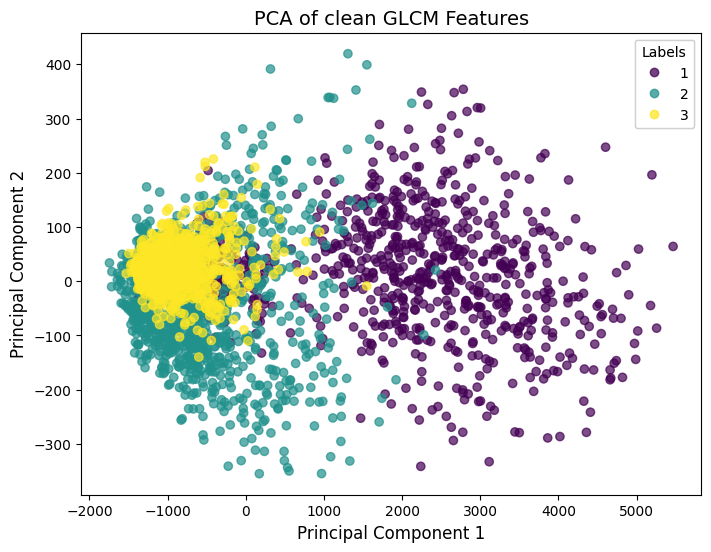

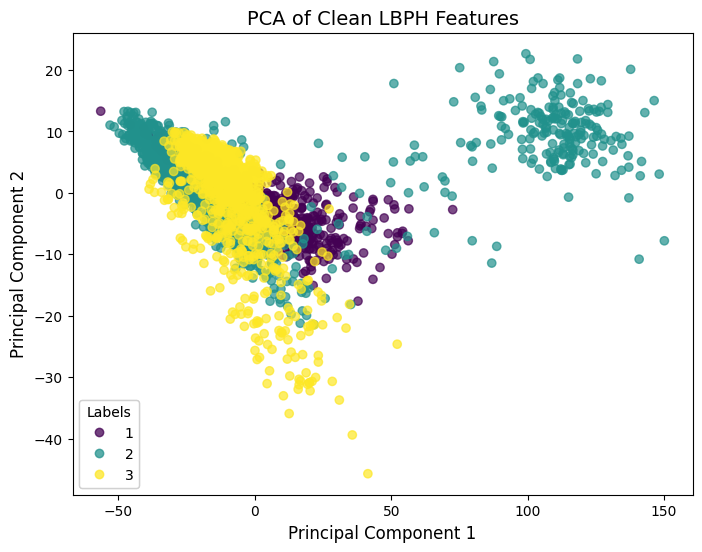

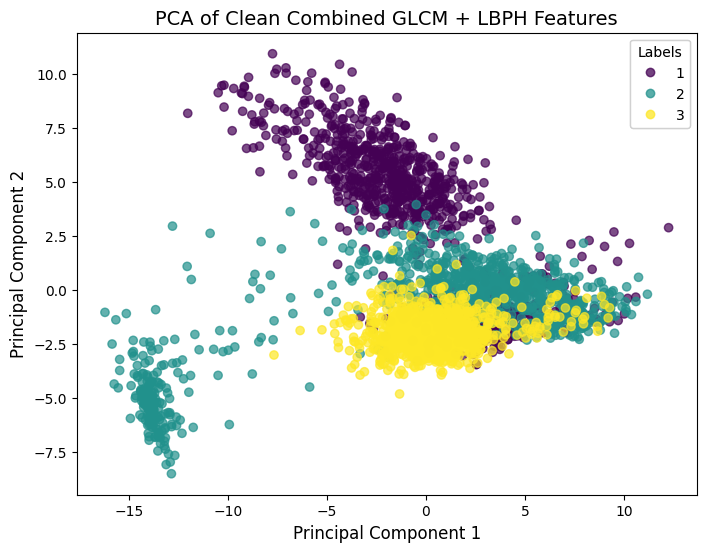

In [183]:
plot_pca(clean_X_glcm, clean_y, title="PCA of clean GLCM Features")
plot_pca(clean_X_lbph, clean_y, title="PCA of Clean LBPH Features")
plot_pca(X_combined_clean, clean_y, title="PCA of Clean Combined GLCM + LBPH Features")

